## Wood synthetic likelihoods for Ricker

Juan Pavez, March 2016.

In this notebook we study the usability of the method [Approximating Likelihood Ratios with Calibrated Discriminative Classifiers](http://inspirehep.net/record/1377273) for times series parameter estimation.



In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import theano
import scipy.linalg as L
import pdb
import pickle

import os, sys, inspect
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder + '/../systematics/carl')

import carl

matplotlib.style.use('ggplot')

np.random.seed(1234)

In [2]:
p_value_ = 1
ndims_ = 1
nparams_ = 2
N_ = 50000
T_ = 50

r_value = 3.8
#r_value = 44.7
#r_bkg = 70.
sigma_2_value = 0.3
phi_value = 10.

shared_r = theano.shared(r_value, name="r")
shared_sigma_2 = theano.shared(sigma_2_value,name="sigma_2")
shared_phi = theano.shared(phi_value, name="phi")
shared_params = [shared_r, shared_phi]

bounds = [(3.5, 3.9), (7.3, 13.4)]
n_points = 10

As = np.linspace(bounds[0][0],bounds[0][1], n_points)
Bs = np.linspace(bounds[1][0],bounds[1][1], n_points)
AA, BB = np.meshgrid(As, Bs)
AABB = np.hstack((AA.reshape(-1, 1),
               BB.reshape(-1, 1)))

class Ricker:
    def __init__(self,r,sigma_2,phi):
        self.r = r
        self.sigma_2 = sigma_2
        self.phi = phi
    
    def sample(self,r=0.5, sigma_2=1., phi=0.1, start=0.1,n_timesteps=1000, rng=None):
        noise = rng.normal(0.,sigma_2, n_timesteps)
        time_serie = np.zeros(n_timesteps,dtype=np.float64)
        time_serie[0] = np.abs(noise[0])
        r_e = np.exp(r)
        #r_e = r
        for i in range(1,n_timesteps):
            time_serie[i] = (r_e*time_serie[i-1]*np.exp(-time_serie[i-1] + noise[i]))

        sampled = np.zeros(n_timesteps)
        sampled = np.array([rng.poisson(phi*time_serie[i]) for i in range(0,n_timesteps,1)])
        
        return_serie = np.log(time_serie[1:]/(time_serie[:-1]))
        
        return time_serie.reshape(time_serie.shape[0],1), sampled.reshape(sampled.shape[0],1),return_serie.reshape(return_serie.shape[0],1)
    def rvs(self,n_samples, random_state=1234):
        rng = np.random.RandomState(random_state) if \
                isinstance(random_state,int) else random_state
        return self.sample(r=self.r.eval(),sigma_2=self.sigma_2.eval(),phi=self.phi.eval(),
                     n_timesteps=n_samples,rng=rng)[1]
                
    
#serie1,sampled1 = ricker(r=np.exp(3.8),sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)
#serie2,sampled2 = ricker(r=np.exp(4.5), sigma_2=0.3**2,phi=10.,n_timesteps=n_samples,start=0.5)

#X_true,X_true_obs = ricker(r=np.exp(3.8),sigma_2=0.3**2,phi=10.,n_timesteps=1500,start=0.5)


In [3]:
p0 = Ricker(r=shared_r,sigma_2=shared_sigma_2,phi=shared_phi)
#p1 = Ricker(r=np.exp(4.5), sigma_2=0.3**2,phi=10.)
rng = np.random.RandomState(1234)

n_true = 1000
#X_true = p0.rvs(1000,random_state=rng)
X_true = np.array([p0.rvs(T_, random_state=np.random.randint(0,5000))
                   for i in range(n_true)])

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
def covariances(X, k, u):
    if len(X.shape) > 1:
        N = X.shape[1]
    else:
        N = X.shape[0]
    return (1./(N-1))* (np.array([(X[:,i+k] - u)*(X[:,i] - u) 
                                      for i in range(N-k)])).sum(axis=0)

# Need to code it for more lags
def differences(X):
    if len(X.shape) > 1:
        X_ = np.zeros((X.shape[0], X.shape[1]-1))
        for k in range(len(X)):
            X_[k] = X[k][1:] - X[k][:-1]
        return X_
    return X[1:] - X[:-1]

def normalize(X):
    if len(X.shape) > 1:
        return X - X.mean(axis=1, keepdims=True)
    return X - X.mean()

# TODO: In the paper Wood doesn't use an itercept term!! (hera I'm using)
def poly_regression(X, y, deg=3):
    reg = np.polyfit(X, y, deg=deg)
    return reg

def poly_autoregression(X_r, X_x, deg=2):
    betas_x = []
    for k in range(X_r.shape[0]):
        keep = ~np.logical_or(np.isnan(X_r[k,:]), np.isnan(X_x[k,:]))
        if np.any(keep):
            X_r_, X_x_ = X_r[k,keep], X_x[k,keep]
            try:
                beta = poly_regression(X_x_, X_r_, deg=deg)
            except ValueError:
                #print('Errors on {0}'.format(k))
                beta = np.array([0.,0.,0.])
        else:
            beta = np.array([0.,0.,0.])
        betas_x.append(beta)
    return np.array(betas_x)

def cubic_regression(y, X, deg=3):
    betas_x = []
    for k in range(X.shape[0]):
        beta = poly_regression(y, X[k], deg=deg)
        betas_x.append(beta)
    return np.array(betas_x)
    
def compute_S(X_true, Xs):
    real = 0
    autoreg_deg = 2
    cubic_deg = 3
    X_true = X_true.reshape(X_true.shape[0], X_true.shape[1])
    Xs = Xs.reshape(Xs.shape[0], Xs.shape[1])
    # Cubic regression on differences
    # Take any X_true as the true value
    X_true_diff = normalize(differences(X_true[real]))
    Xs_diff = normalize(differences(Xs))
    for k in range(Xs_diff.shape[0]):
        Xs_diff[k].sort()
    X_true_diff.sort()
    diff_reg_x = cubic_regression(X_true_diff, Xs_diff, cubic_deg)
    # Assuming regression equal y    
    Xs_true_diff = normalize(differences(X_true))
    for k in range(Xs_true_diff.shape[0]):
        Xs_true_diff[k].sort()
    diff_reg_y = cubic_regression(X_true_diff, Xs_true_diff, cubic_deg)
    # Polynomial Autoregression
    Xs_n = normalize(Xs)
    X_r =  np.array([xs[1:]**0.3 for xs in Xs_n])
    X_x =  np.array([xs[:-1]**0.3 for xs in Xs_n])
    y_n = normalize(X_true)
    y_r =  np.array([xs[1:]**0.3 for xs in y_n])
    y_x =  np.array([xs[:-1]**0.3 for xs in y_n])

    betas_x = poly_autoregression(X_r, X_x, autoreg_deg)
    betas_y = poly_autoregression(y_r, y_x)
    #betas_y = np.zeros((y_r.shape[0], autoreg_deg + 1))
    #betas_y[:,1] = 1.
    # Autocovariances to lag 5
    u_x = Xs.mean(axis=1)
    covs_x =np.array([covariances(Xs, k, u_x) for k in range(6)])
    u_y = X_true.mean(axis=1)
    covs_y = np.array([covariances(X_true, k, u_y) for k in range(6)])
    # Number of zeros observed
    zeros_x = (Xs == 0.).sum(axis=1)
    zeros_y = (X_true == 0.).sum(axis=1)
    S_x = [np.hstack((diff_reg_x[k], betas_x[k], covs_x[:,k], u_x[k], zeros_x[k]))
           for k in range(Xs.shape[0])]
    S_y = [np.hstack((diff_reg_y[k], betas_y[k], covs_y[:,k], u_y[k], zeros_y[k])) 
           for k in range(X_true.shape[0])]
    #S_x = [np.hstack((betas_x[k], covs_x[:,k], u_x[k], zeros_x[k]))
    #       for k in range(Xs.shape[0])]
    #S_y = [np.hstack((betas_y[k], covs_y[:,k], u_y[k], zeros_y[k])) 
    #       for k in range(X_true.shape[0])]
    return (S_x, S_y)

In [6]:
from itertools import product
bounds_values = [(np.linspace(bounds[0][0],bounds[0][1], num=n_points)),
                 (np.linspace(bounds[1][0],bounds[1][1], num=n_points))]
combinations = list(product(*bounds_values))

In [7]:
print(len(combinations))

100


In [8]:
Xs = []

for k,value in enumerate(combinations):
    for i,v in enumerate(value):
        shared_params[i].set_value(v)
    print(k),
    X0_ = np.array([p0.rvs(T_, random_state=np.random.randint(0,5000))
                   for i in range(N_//2)])
    Xs.append(X0_)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99


In [9]:
Xs = np.array(Xs)
print(Xs.shape)

(100, 25000, 50, 1)


In [10]:
import seaborn

In [11]:
Xs_s = []
for k in range(Xs.shape[0]):
    print(k),
    s, y_s = compute_S(X_true, Xs[k])
    Xs_s.append(s)
Xs_s = np.array(Xs_s)
X_true_s = np.array(y_s)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99


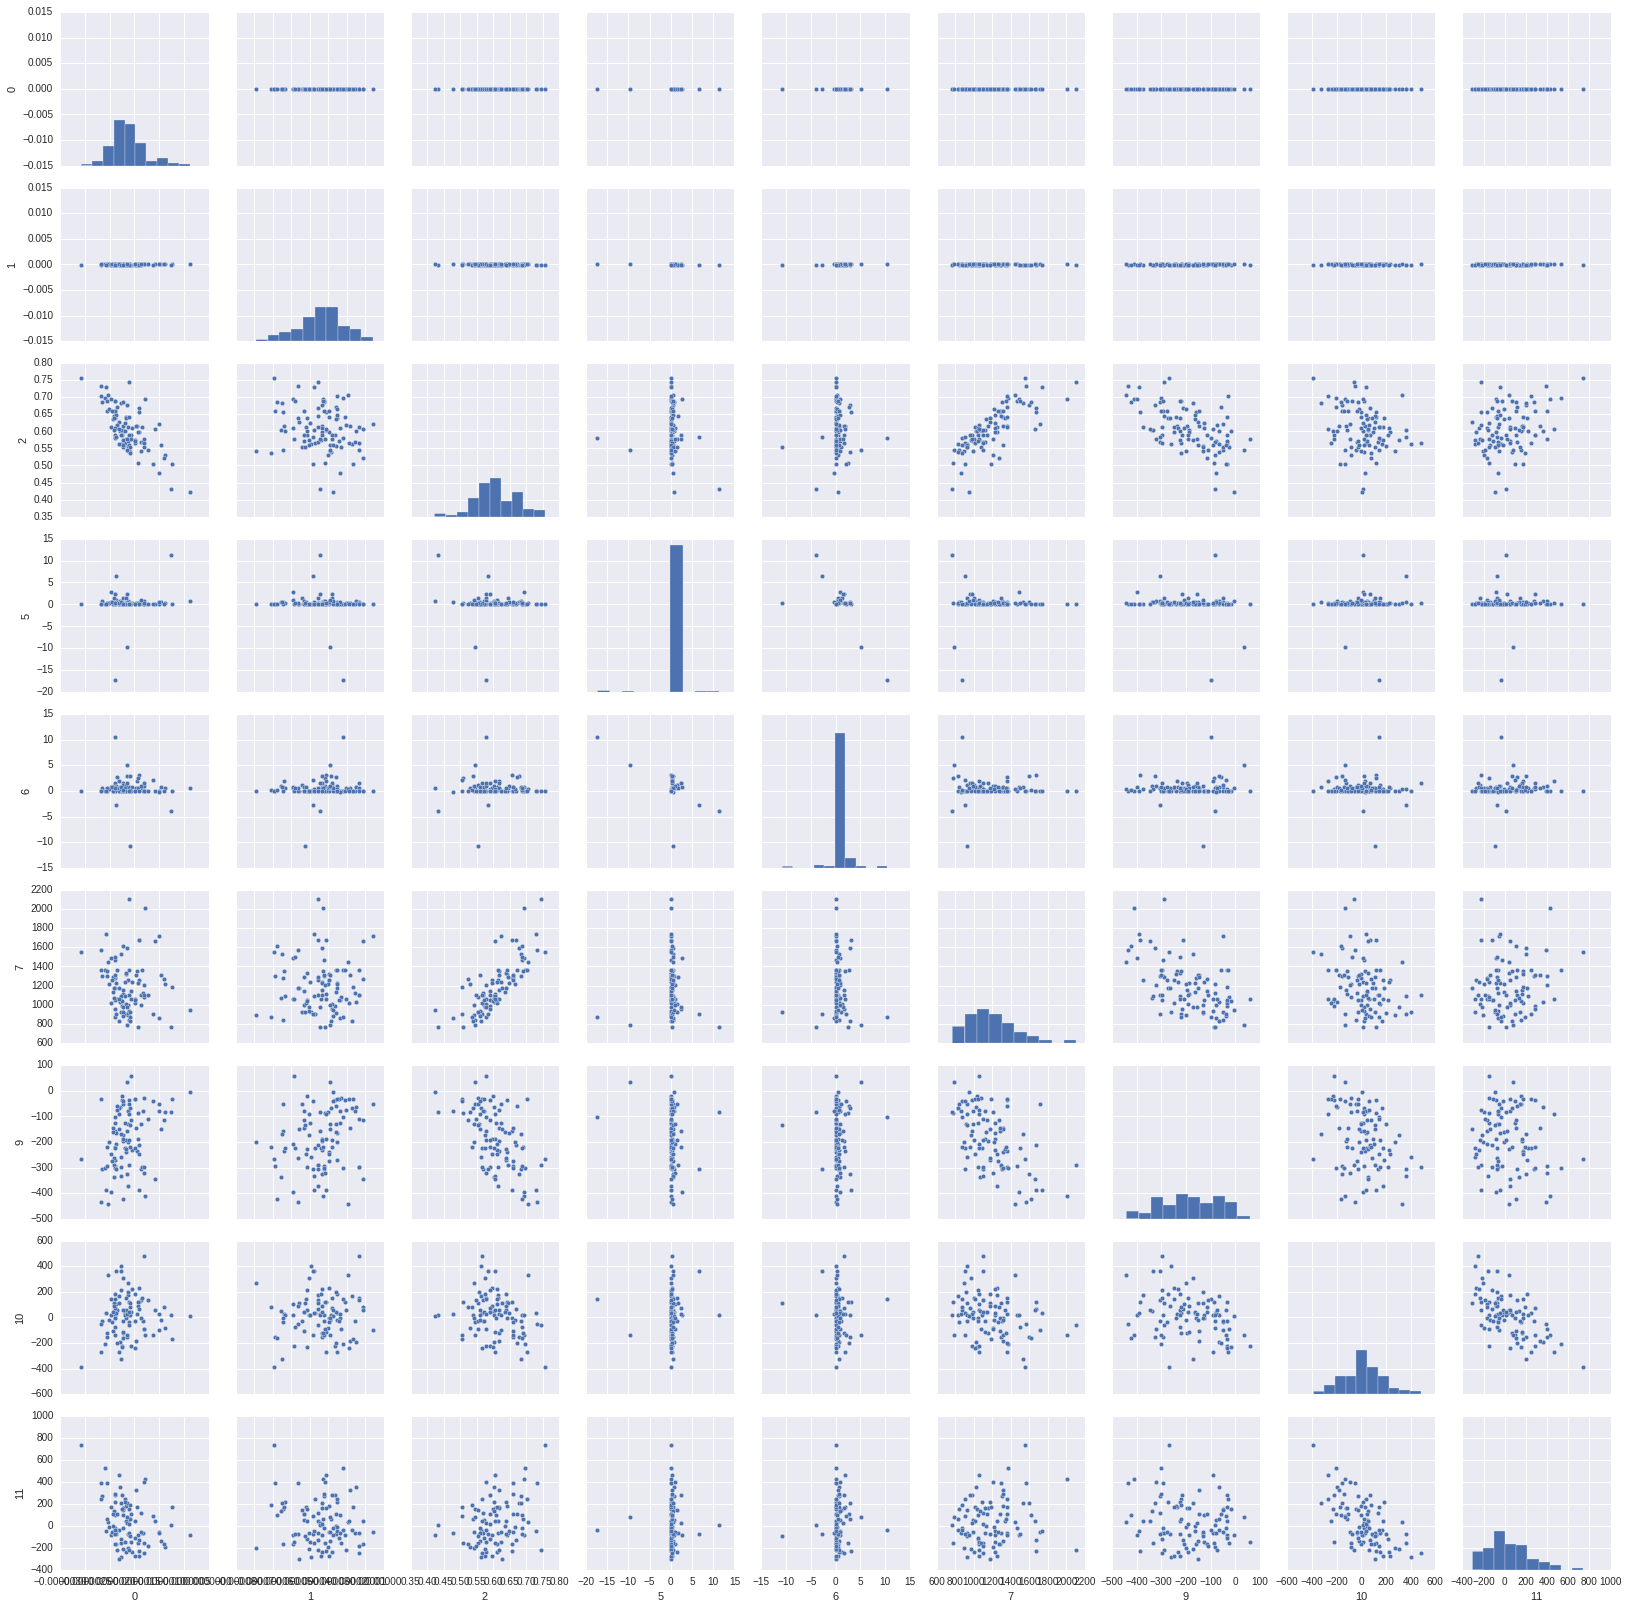

In [14]:
dt = pd.DataFrame(Xs_s[0][:100])
g = seaborn.pairplot(dt, vars=[0,1,2,5,6,7,9,10,11])

0 118


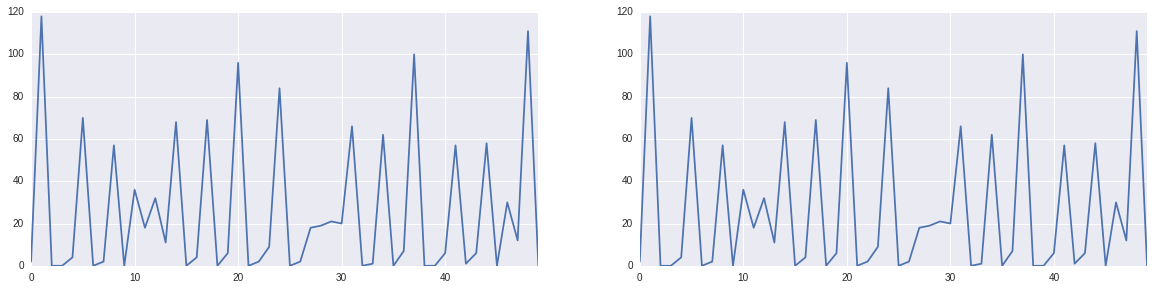

In [15]:
serie1 = Xs[0][0][:,0]
plt.figure(figsize=(20,10))
plt.subplot(221)
ts = pd.Series(serie1)
ts[0:100].plot()
plt.subplot(222)
ts = pd.Series(serie1)
ts.plot()
print serie1.min(),serie1.max()

In [16]:
from carl.distributions import MultivariateNormal
means = []
covs = []
normals = []
for k, X in enumerate(Xs_s):
    covs.append(np.cov(X, rowvar=0))
    means.append(np.mean(X, axis=0))
    #normals.append(MultivariateNormal(mu=means[-1], sigma=covs[-1]))

In [17]:
from scipy.stats import multivariate_normal

def mvn_fit(X, mean, cov):
    return -np.log(multivariate_normal.pdf(X, 
                                         mean=mean, cov=cov, allow_singular=True))


In [ ]:
llr = []

for i, theta in enumerate(combinations):
    #print(i, theta)
    nlls = mvn_fit(X_true_s, means[i], covs[i])
    #print nlls[np.isinf(nlls)].shape
    nlls = nlls[np.logical_and(np.isfinite(nlls),~np.isnan(nlls))]
    nll = np.mean(nlls) 
    llr.append(nll)
    #nllr = ratio.nnlr(X_observed)
    #llr.append(ratio.nllr(X_true))
    #print(llr[-1])

In [19]:
llr = np.array(llr)
llr[np.isnan(llr)] = 0.
llr_original = llr.copy()
#llr *= 19.2 / len(X_true)

([10.011111111111111], [3.7666666666666666])


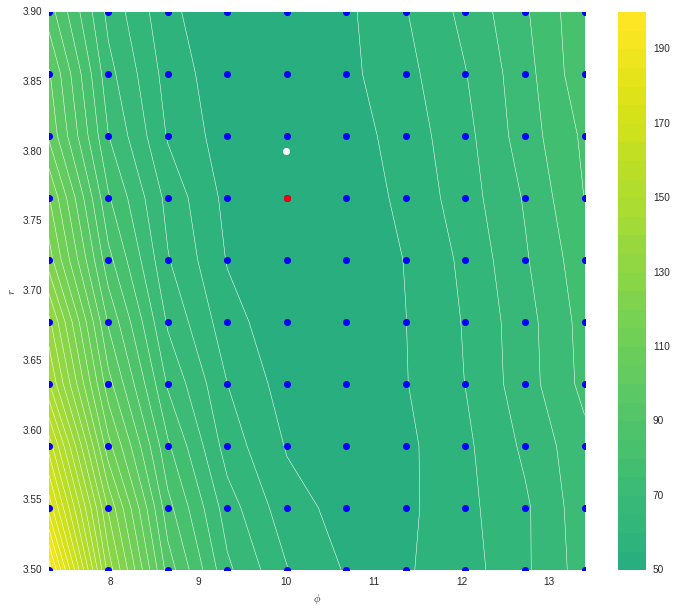

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
plt.rcParams["figure.figsize"] = (12, 10)

xi = np.linspace(bounds[0][0], bounds[0][1], 10)
yi = np.linspace(bounds[1][0], bounds[1][1], 10)
thetas = np.array([v for v in product(As, Bs)])
zi = griddata(thetas[:, 0], thetas[:, 1], llr, xi, yi, interp='linear')
mle = np.unravel_index(zi.argmin(),zi.shape)
#zi = zi.transpose()
print([yi[mle[0]]], [xi[mle[1]]])
xx, yy = np.meshgrid(xi,yi)

cs = plt.contour(yy, xx, zi, 30, linewidths=0.5, colors='w')
cs = plt.contourf(yy, xx, zi, 30, cmap="viridis",
                 vmax=abs(zi).max(), vmin=-abs(zi).max())
plt.clim(50,180)
plt.colorbar()  
plt.scatter(thetas[:,1],thetas[:,0], marker='o', c='b', s=50, lw=0, zorder=10)
plt.scatter([phi_value],[r_value], marker='o', c='w', s=50, lw=0, zorder=10)
plt.scatter([yi[mle[0]]], [xi[mle[1]]], marker='o', c='r', s=50, lw=0, zorder=10)

plt.xlim(bounds[1][0], bounds[1][1])
plt.ylim(bounds[0][0], bounds[0][1])
plt.xlabel(r"$\phi$")
plt.ylabel(r"$r$")
plt.show()

[  3.76938776  10.03877551]


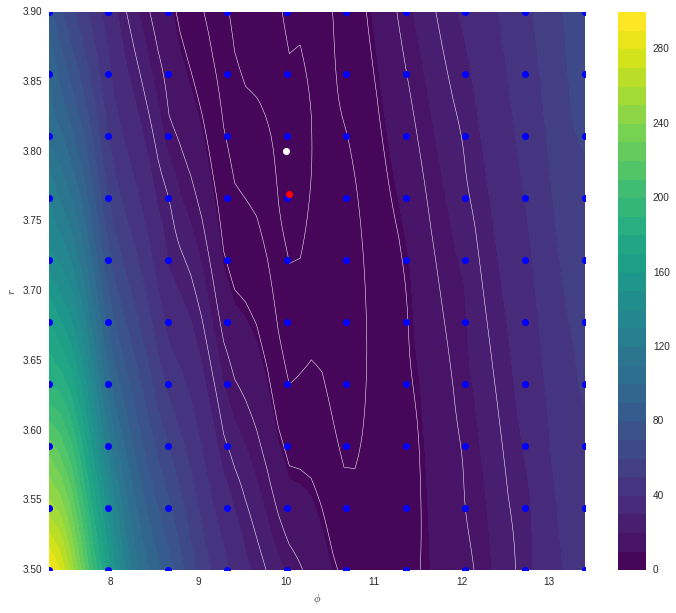

In [21]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, Matern
from sklearn.metrics import log_loss

thetas = np.array([v for v in product(As, Bs)])

gp = GaussianProcessRegressor(alpha=0., normalize_y=True, 
                              kernel=C(1.0) * Matern(1.0, length_scale_bounds="fixed"))
gp.fit(thetas, llr)

xi = np.linspace(bounds[0][0], bounds[0][1], 50)
yi = np.linspace(bounds[1][0], bounds[1][1], 50)
    
xx, yy = np.meshgrid(xi, yi)
zz, std = gp.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
zi = zz.reshape(xx.shape)

mle_2 = np.unravel_index(zi.argmin(),zi.shape)
zi -= zi[mle_2]
print(np.c_[xx.ravel(), yy.ravel()][zi.argmin()])
zi *= 2.
zi = zi.transpose()

cs = plt.contour(yi, xi, zi, [1.,4.,9.,16.,25.], linewidths=0.5, colors='w')
cs = plt.contourf(yi, xi, zi, 30, cmap="viridis",
                  vmax=abs(zi).max(), vmin=0.0)

plt.colorbar()
plt.scatter(thetas[:,1],thetas[:,0], marker='o', c='b', s=50, lw=0, zorder=10)
plt.scatter([yi[mle_2[0]]], [xi[mle_2[1]]], marker='o', c='r', s=50, lw=0, zorder=10)
plt.scatter([phi_value],[r_value], marker='o', c='w', s=50, lw=0, zorder=10)

plt.xlim(bounds[1][0], bounds[1][1])
plt.ylim(bounds[0][0], bounds[0][1])
plt.xlabel(r"$\phi$")
plt.ylabel(r"$r$")
